# Attenuation Analysis of Lead and Aluminum Against Gamma Ray Sources
**Goal**: To compute the attenuation constants for two different materials, Aluminum (Al) and Lead (Pb).  We setup a gamma ray source under the Na detector and progressively put more shielding of the material between the source and detector.  The ability of the material to absorb or *"shield"* the radiation can be quantified by its attenuation constant.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", palette='tab10')

In [2]:
xls = pd.ExcelFile('data/lead_data.xlsx')
first_experiment = 'lead_v1'
second_experiment = 'lead_v2'
df1 = pd.read_excel(xls, first_experiment)
df1.head()

,time,lead (mm),count
0,1,0.0,764
1,2,0.0,820
2,3,0.0,756
3,4,0.0,835
4,5,0.0,841


Converting from mm to cm

In [3]:
df1['lead (mm)'] = df1['lead (mm)'] / 10.
df1 = df1.rename(columns={'lead (mm)': 'lead (cm)'})

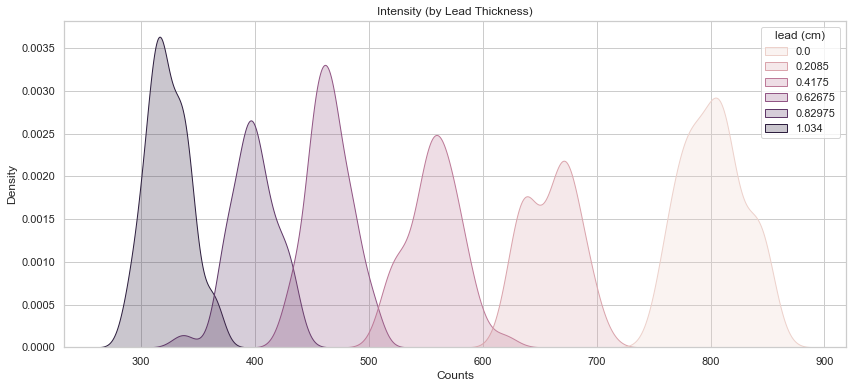

In [4]:
plt.figure(figsize=(14,6))
sns.kdeplot(data=df1, x='count', hue='lead (cm)', fill=True)
plt.xlabel('Counts')
plt.title('Intensity (by Lead Thickness)')
plt.show()

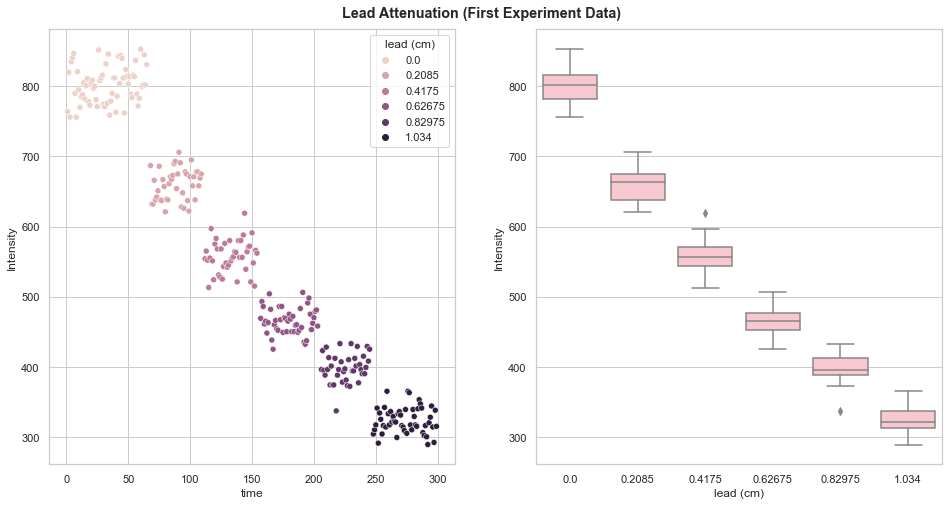

In [5]:
fig, axes = plt.subplots(1,2, figsize=(16,8))

sns.scatterplot(ax=axes[0], data=df1, x='time', y='count', hue='lead (cm)')
axes[0].set_ylabel('Intensity')
sns.boxplot(ax=axes[1], data=df1, x='lead (cm)', y='count', color='pink')
plt.suptitle('Lead Attenuation (First Experiment Data)', y=0.92, fontweight='bold')
axes[1].set_ylabel('Intensity')
plt.show()

**Outliers:** These two graphs, but especially the boxplot on the right makes it clear there's a pair of outliers in the data.  In the 4.175 (3rd) lead group there's one that's pretty high, and on the 8.3 lead (next to last) there's one that's very low.  They're in the middle of the data roughly, so it's not like they belong to the neighboring groups.  In the end they don't seem to have much of an impact on the data so I'll ignore them for now.  If I have more time I might bother removing them and comparing the difference in results.

In [6]:
# Aggregating the data by lead thickness
lead_1 = df1.loc[:, ['lead (cm)', 'count']].groupby('lead (cm)').agg(['mean', 'std', 'count', 'median', 'max'])
lead_1.columns = lead_1.columns.get_level_values(1).astype(str)
lead_1

,mean,std,count,median,max
lead (cm),,,,,
0.00000,802.246154,26.465798,65,802.0,853
0.20850,659.928571,22.545772,42,663.5,706
0.41750,557.255814,23.177465,43,556.0,619
0.62675,465.085106,18.597370,47,465.0,506
0.82975,398.350000,20.372870,40,396.0,433
1.03400,323.538462,18.324377,52,320.5,365


## Errors & Uncertainty
For the uncertainties in the counts, the Taylor book recommends for a counting problem like this to take the square root of the value you counted, $\sqrt{y}$.  Since we also have the count of how many counts we had, i.e. For 0 amount of lead there's about 800, but we had 65 data points there so the $\delta_y = \sqrt{\frac{y}{n}}$

And then lastly the dwell time was set to 2 seconds here, so to get the actual activity of counts / sec we'll divide by 2.  We won't round these values yet as we'll be converting over into a logarithm later to make a more linear fit.

In [7]:
lead_1['delta_count'] = np.sqrt(lead_1['mean'] / lead_1['count'])
lead_1['mean'] = lead_1['mean'] / 2.0
lead_1['delta_count'] = lead_1['delta_count'] / 2.0
lead_1

,mean,std,count,median,max,delta_count
lead (cm),,,,,,
0.00000,401.123077,26.465798,65,802.0,853,1.756577
0.20850,329.964286,22.545772,42,663.5,706,1.981955
0.41750,278.627907,23.177465,43,556.0,619,1.799961
0.62675,232.542553,18.597370,47,465.0,506,1.572850
0.82975,199.175000,20.372870,40,396.0,433,1.577874
1.03400,161.769231,18.324377,52,320.5,365,1.247186


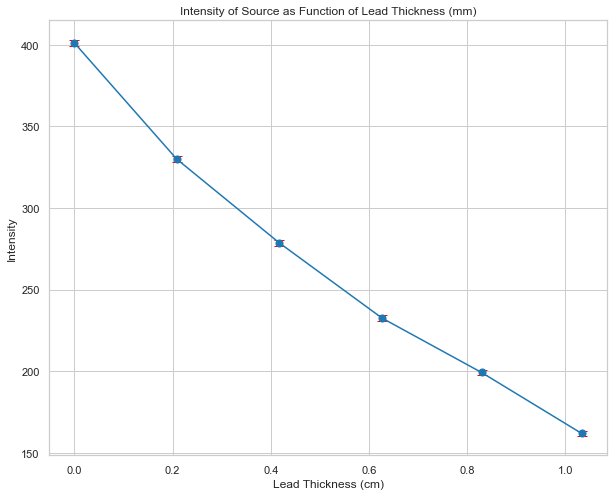

In [8]:
fig, ax = plt.subplots(figsize=(10,8))

ax.errorbar(lead_1.index, lead_1['mean'], yerr=lead_1['delta_count'], fmt='none', color='r', capsize=5, zorder=1)
ax.scatter(lead_1.index, lead_1['mean'], s=50, zorder=2)
ax.plot(lead_1.index, lead_1['mean'])
plt.title('Intensity of Source as Function of Lead Thickness (mm)')
plt.xlabel('Lead Thickness (cm)')
plt.ylabel('Intensity')
plt.show()

## Finding $\mu$, the Linear Attenuation Coefficient of L
We can directly compute it from this data.  The formula is:

$$I(x) = I_0 e^{-\mu x}$$
$$\mu = -\frac{1}{x}ln\left(\frac{I(x)}{I_0}\right)$$
$$$$

$$\frac{I(x)}{I_0} = e^{-\mu x}$$
$$ln\left(\frac{I(x)}{I_0}\right) = -\mu x$$

We can introduce $\frac{\rho}{\rho}$ to put this in terms of the mass attenuation coefficient $(\frac{\mu}{\rho})$ which is sometimes tracked instead of just the linear attenuation coefficient.

$$ln\left(\frac{I(x)}{I_0}\right) = -\mu \frac{\rho}{\rho} x$$
$$ln\left(\frac{I(x)}{I_0}\right) = -\frac{\mu}{\rho} (\rho x)$$
$$ln\left(\frac{I(x)}{I_0}\right) = -\frac{\mu}{\rho} (\rho x)$$
$$ln(I(x)) - ln(I_0) = -\frac{\mu}{\rho} (\rho x)$$
$$ln(I(x)) = ln(I_0) - \frac{\mu}{\rho} (\rho x)$$

This is now in a linear form, where $ln(I(x))$ is the new y-value to track, the slope is the mass attenuation coefficient $\frac{\mu}{\rho}$, and the x-value will be $\rho x$ instead of just $x$, the thickness of the lead.  $\rho$ is the density of lead.

## Error Adjustment
Since we're applying the logarithm function to the count (mean) we'll have to adjust the uncertainty as well.  Per Taylor's error analysis book in this case we just replace $\delta_x$ with $\frac{\delta_x}{x}$.

In [9]:
lead_1.loc[:, 'ln(I)'] = np.log(lead_1.loc[:, 'mean'])
lead_1.loc[:, 'ln(delta_count)'] = lead_1['delta_count'] / lead_1['mean']
lead_1

,mean,std,count,median,max,delta_count,ln(I),ln(delta_count)
lead (cm),,,,,,,,
0.00000,401.123077,26.465798,65,802.0,853,1.756577,5.994268,0.004379
0.20850,329.964286,22.545772,42,663.5,706,1.981955,5.798984,0.006007
0.41750,278.627907,23.177465,43,556.0,619,1.799961,5.629877,0.006460
0.62675,232.542553,18.597370,47,465.0,506,1.572850,5.449073,0.006764
0.82975,199.175000,20.372870,40,396.0,433,1.577874,5.294184,0.007922
1.03400,161.769231,18.324377,52,320.5,365,1.247186,5.086171,0.007710


In [10]:
p_lead = 11.29
lead_1.loc[:, 'px'] = lead_1.index * p_lead
lead_1

,mean,std,count,median,max,delta_count,ln(I),ln(delta_count),px
lead (cm),,,,,,,,,
0.00000,401.123077,26.465798,65,802.0,853,1.756577,5.994268,0.004379,0.000000
0.20850,329.964286,22.545772,42,663.5,706,1.981955,5.798984,0.006007,2.353965
0.41750,278.627907,23.177465,43,556.0,619,1.799961,5.629877,0.006460,4.713575
0.62675,232.542553,18.597370,47,465.0,506,1.572850,5.449073,0.006764,7.076008
0.82975,199.175000,20.372870,40,396.0,433,1.577874,5.294184,0.007922,9.367877
1.03400,161.769231,18.324377,52,320.5,365,1.247186,5.086171,0.007710,11.673860


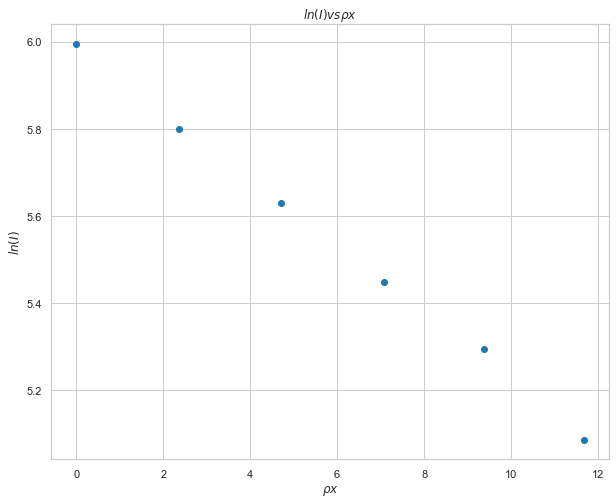

In [11]:

plt.figure(figsize=(10,8))
plt.scatter(lead_1['px'], lead_1['ln(I)'])
plt.xlabel(r'$\rho x$')
plt.ylabel(r'$ln(I)$')
plt.title(r'$ln(I) vs \rho x$')
plt.show()

In [12]:
from sklearn.linear_model import LinearRegression

x = lead_1['px'].to_numpy().reshape(-1,1)
y = lead_1['ln(I)'].to_numpy().reshape(-1,1)
y_err = lead_1['ln(delta_count)'].to_numpy().reshape(-1,1)

model = LinearRegression().fit(x, y)
model.score(x, y)

0.9987785444016009

In [13]:
print('Slope of fit: ',round(float(model.coef_), 4))

Slope of fit:  -0.0763


In [14]:
u_lead = -1 * float(model.coef_)
print(f' u of lead: {u_lead:.3f}')

 u of lead: 0.076


In [15]:
# Combining to calculate errors:
data = np.concatenate((x, y, y_err), axis=1)
data

array([[0.00000000e+00, 5.99426831e+00, 4.37914676e-03],
       [2.35396500e+00, 5.79898442e+00, 6.00657479e-03],
       [4.71357500e+00, 5.62987722e+00, 6.46008851e-03],
       [7.07600750e+00, 5.44907323e+00, 6.76370807e-03],
       [9.36787750e+00, 5.29418384e+00, 7.92205026e-03],
       [1.16738600e+01, 5.08617082e+00, 7.70966256e-03]])

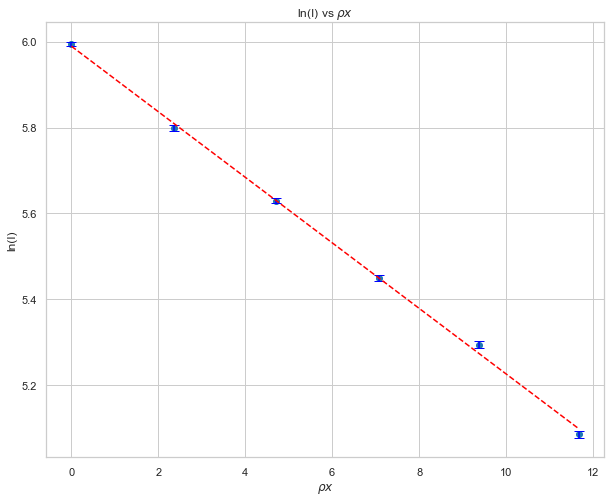

In [16]:
y_hat = model.predict(x)

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(x, y)
ax.plot(x, y_hat, linestyle='--', color='red')
ax.errorbar(data[:,0], 
            data[:,1], 
            yerr=data[:,2], fmt='none', color='b', capsize=5, zorder=1)
ax.set_title(r'ln(I) vs $\rho x$')
ax.set_xlabel(r'$\rho x$')
ax.set_ylabel('ln(I)')
plt.show()

In [17]:
u_lead = float(model.coef_) * -11.3
print(f'Lead Linear Attenuation Coefficient: {u_lead:.2f}')
# should be about 0.903 cm^-1

Lead Linear Attenuation Coefficient: 0.86


In [18]:
u_lead_px = -1 * float(model.coef_)
print(f'Lead Mass Attenuation Coefficient {u_lead_px:.3f}')
# Should be about 0.07976 cm^2/g

Lead Mass Attenuation Coefficient 0.076


In [19]:
lead_1['y_hat'] = y_hat
#lead_1[['y_hat']] - lead_1[['ln(I)']]
lead_1

,mean,std,count,median,max,delta_count,ln(I),ln(delta_count),px,y_hat
lead (cm),,,,,,,,,,
0.00000,401.123077,26.465798,65,802.0,853,1.756577,5.994268,0.004379,0.000000,5.989254
0.20850,329.964286,22.545772,42,663.5,706,1.981955,5.798984,0.006007,2.353965,5.809758
0.41750,278.627907,23.177465,43,556.0,619,1.799961,5.629877,0.006460,4.713575,5.629832
0.62675,232.542553,18.597370,47,465.0,506,1.572850,5.449073,0.006764,7.076008,5.449691
0.82975,199.175000,20.372870,40,396.0,433,1.577874,5.294184,0.007922,9.367877,5.274930
1.03400,161.769231,18.324377,52,320.5,365,1.247186,5.086171,0.007710,11.673860,5.099093


## $\tilde{X}^2$ for the Lead Attenuation Fit

In [20]:
X2 = (((lead_1['y_hat'].to_numpy() - lead_1['ln(I)'].to_numpy()) / (lead_1['ln(delta_count)']))**2).sum() / 4
#round(X2, 3)
print(f'Reduced X^2: {X2:.3f}')

Reduced X^2: 3.313


A bit high at 3.3 for $X^2$.

In [21]:
model.coef_

array([[-0.0762525]])

In [22]:
model.intercept_

array([5.98925398])